In [1]:
import numpy as np
np.random.seed(42)
import random as rn
rn.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.base import BaseEstimator

from keras.layers import Input, Embedding, Dense,Flatten,\
    Concatenate,dot,Activation,Reshape,BatchNormalization,concatenate,Dropout,add,\
    RepeatVector,merge,multiply,Lambda
from keras.models import Model
from keras.regularizers import l2 as l2_reg
#from keras import initializations
import itertools
from keras import backend  as KK
from keras.engine.topology import Layer
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import *

Using TensorFlow backend.


## scoring function

In [2]:
def binary_crossentropy_with_ranking(y_true, y_pred):
    """ Trying to combine ranking loss with numeric precision"""
    # first get the log loss like normal
    logloss = KK.mean(KK.binary_crossentropy( y_true,y_pred), axis=-1)
    # next, build a rank loss
    # clip the probabilities to keep stability
    y_pred_clipped = KK.clip(y_pred, KK.epsilon(), 1-KK.epsilon())
    # translate into the raw scores before the logit
    y_pred_score = KK.log(y_pred_clipped / (1 - y_pred_clipped))
    # determine what the maximum score for a zero outcome is
    y_pred_score_zerooutcome_max = KK.max(tf.boolean_mask(y_pred_score ,(y_true < 1)))
    # determine how much each score is above or below it
    rankloss = y_pred_score - y_pred_score_zerooutcome_max
    # only keep losses for positive outcomes
    rankloss = tf.boolean_mask(rankloss,tf.equal(y_true,1))
    # only keep losses where the score is below the max
    rankloss = KK.square(KK.clip(rankloss, -100, 0))
    # average the loss for just the positive outcomes
    #tf.reduce_sum(tf.cast(myOtherTensor, tf.float32))
    rankloss = KK.sum(rankloss, axis=-1) / (KK.sum(KK.cast(y_true > 0,tf.float32) + 1))
    return (rankloss + 1)* logloss #- an alternative to try
    #return logloss

# PFA, prob false alert for binary classifier  
def binary_PFA(y_true, y_pred, threshold=KK.variable(value=0.5)):  
    y_pred = KK.cast(y_pred >= threshold, 'float32')  
    # N = total number of negative labels  
    N = KK.sum(1 - y_true)  
    # FP = total number of false alerts, alerts from the negative class labels  
    FP = KK.sum(y_pred - y_pred * y_true)  
    return FP/N 


# P_TA prob true alerts for binary classifier  
def binary_PTA(y_true, y_pred, threshold=KK.variable(value=0.5)):  
    y_pred = KK.cast(y_pred >= threshold, 'float32')  
    # P = total number of positive labels  
    P = KK.sum(y_true)  
    # TP = total number of correct alerts, alerts from the positive class labels  
    TP = KK.sum(y_pred * y_true)  
    return TP/P

def auc(y_true, y_pred):  
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)  
    binSizes = -(pfas[1:]-pfas[:-1])  
    s = ptas*binSizes  
    return KK.sum(s, axis=0)  


def log_loss(y_true, y_pred):
    """ Trying to combine ranking loss with numeric precision"""
    # first get the log loss like normal
    logloss = KK.sum(KK.binary_crossentropy(y_true,y_pred), axis=-1)
    return logloss

## Data Loading

In [3]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","TA_User_Reviws_Korea_all_v2_new_df.csv"))
df.head()

,locationId,rated_count,average_photonum,average_rating,userID,users_mean_rating,user_reviewcount,rating,location_name,placeType,createdDate,islocal,photonum
0,299152,13,2.846154,3.692308,4842,3.677083,96,5,Best Western Premier Seoul Garden Hotel,ACCOMMODATION,20171009,1,12
1,299152,13,2.846154,3.692308,9212,3.791667,240,3,Best Western Premier Seoul Garden Hotel,ACCOMMODATION,20180306,1,0
2,299152,13,2.846154,3.692308,14262,4.500000,2,4,Best Western Premier Seoul Garden Hotel,ACCOMMODATION,20121220,0,1
3,299152,13,2.846154,3.692308,20235,3.000000,4,1,Best Western Premier Seoul Garden Hotel,ACCOMMODATION,20161127,0,4
4,299152,13,2.846154,3.692308,21432,4.200000,5,4,Best Western Premier Seoul Garden Hotel,ACCOMMODATION,20120416,0,0


# 로컬 / 글로벌 데이터 분리

In [4]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['islocal']==1]
global_df = df.loc[df['islocal']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (43294, 13) global_df shape : (94196, 13)


In [5]:
# 범주형 원핫인코딩화 
local_dummies = pd.get_dummies(local_df, columns=['placeType']) 
localdf = local_dummies.drop(columns = 'location_name')
localdf.head()

,locationId,rated_count,average_photonum,average_rating,userID,users_mean_rating,user_reviewcount,rating,createdDate,islocal,photonum,placeType_ACCOMMODATION,placeType_EATERY
0,299152,13,2.846154,3.692308,4842,3.677083,96,5,20171009,1,12,1,0
1,299152,13,2.846154,3.692308,9212,3.791667,240,3,20180306,1,0,1,0
8,299152,13,2.846154,3.692308,42121,4.142857,7,4,20150823,1,0,1,0
14,299154,75,1.653333,4.240000,2995,4.484848,33,5,20150805,1,0,1,0
15,299154,75,1.653333,4.240000,3102,4.000000,19,4,20150930,1,0,1,0


In [6]:
# 범주형 원핫인코딩화 
global_dummies = pd.get_dummies(global_df, columns=['placeType']) 
globaldf = global_dummies.drop(columns = 'location_name')
globaldf.head()

,locationId,rated_count,average_photonum,average_rating,userID,users_mean_rating,user_reviewcount,rating,createdDate,islocal,photonum,placeType_ACCOMMODATION,placeType_EATERY
2,299152,13,2.846154,3.692308,14262,4.5,2,4,20121220,0,1,1,0
3,299152,13,2.846154,3.692308,20235,3.0,4,1,20161127,0,4,1,0
4,299152,13,2.846154,3.692308,21432,4.2,5,4,20120416,0,0,1,0
5,299152,13,2.846154,3.692308,21920,4.5,2,5,20120820,0,3,1,0
6,299152,13,2.846154,3.692308,29611,4.5,4,4,20180703,0,0,1,0


### global 진행

In [7]:
dfTrain = globaldf.iloc[0:int(0.7*globaldf.shape[0]),:]
dfTest = globaldf.iloc[int(0.7*globaldf.shape[0]):,:]

print(dfTrain.shape, dfTest.shape)

(65937, 13) (28259, 13)


### 데이터 전처리

In [8]:
# 모든 피쳐 
global_columns  = dfTrain.columns.tolist()
# divide the columns by CATEGORICAL columns ID_columns 
ID_columns  = ['placeType_ACCOMMODATION', 'placeType_EATERY']

qid_columns = ['userID']
target_columns = ['rating']

###----global remove other columns---##
# x(userid), y(rating), 범주형 변수 제외한 연속형 변수 
continue_cols = global_columns[:]
[continue_cols.remove(x) for x in target_columns]
[continue_cols.remove(x) for x in ID_columns]
[continue_cols.remove(x) for x in qid_columns]

####continue plus id columns----###
# 범주형 변수 + 연속형 변수 = x(userid), y(rating) 제외한 모든 변수
all_feature = ID_columns[:]
all_feature.extend(continue_cols)

In [9]:
continue_cols

['locationId',
 'rated_count',
 'average_photonum',
 'average_rating',
 'users_mean_rating',
 'user_reviewcount',
 'createdDate',
 'islocal',
 'photonum']

In [10]:
all_feature

['placeType_ACCOMMODATION',
 'placeType_EATERY',
 'locationId',
 'rated_count',
 'average_photonum',
 'average_rating',
 'users_mean_rating',
 'user_reviewcount',
 'createdDate',
 'islocal',
 'photonum']

In [11]:
col_index = []
# 피쳐들의 전체 피쳐에서의 인덱싱 넘버 
for col in  all_feature:
    col_index.append(global_columns.index(col))

# 타켓 변수 인덱싱 넘버 
target_col =  global_columns.index(target_columns[0])

all_data = dfTrain.append(dfTest)

In [12]:
###----------make sure the ids max columns number---###
# 각 범주형 원핫인코더 변수의 고유 unique 개수 
max_features = {}
for i in range(len(ID_columns)):
    max_features[ID_columns[i]]=(all_data[ID_columns[i]].unique().shape[0])   
    
max_features

{'placeType_ACCOMMODATION': 2, 'placeType_EATERY': 2}

In [13]:
del all_data

In [14]:
max_features_df = pd.DataFrame(data = np.array([list(max_features.keys()),list(max_features.values())]).T,columns=['ids','max_features'],index=range(len(max_features)))
max_features_df

,ids,max_features
0,placeType_ACCOMMODATION,2
1,placeType_EATERY,2


In [15]:
max_features = pd.merge(pd.DataFrame(ID_columns,columns=['ids']),max_features_df,on=['ids'])
max_features.max_features = max_features.max_features.astype(int)
max_features

,ids,max_features
0,placeType_ACCOMMODATION,2
1,placeType_EATERY,2


In [16]:
max_features = max_features.max_features.tolist()
max_features

[2, 2]

In [17]:
ID_columns

['placeType_ACCOMMODATION', 'placeType_EATERY']

In [18]:
dfTrain['placeType_ACCOMMODATION']

2        1
3        1
4        1
5        1
6        1
        ..
87035    1
87036    1
87037    1
87038    1
87039    1
Name: placeType_ACCOMMODATION, Length: 65937, dtype: uint8

In [19]:
def dis_sparse(concat_train,concat_test,one_hot=True):
    from sklearn.preprocessing import OneHotEncoder,LabelEncoder     
    lbl = LabelEncoder() 
    # 문자 수치화 
    l = np.vstack((concat_train,concat_test))
    l = np.unique(l)    
    lbl.fit(l.reshape(-1,1))
    # labelencoder된 유니크한 넘파이 train, test 데이터셋 반환 
    concat_train= lbl.transform(concat_train.reshape(-1,1))
    concat_test = lbl.transform(concat_test.reshape(-1,1))
    if(one_hot==True):
        one_clf = OneHotEncoder()
        l = np.vstack((concat_train.reshape(-1,1),concat_test.reshape(-1,1)))
        l = np.unique(l)    
        one_clf.fit(l.reshape(-1,1))
        sparse_training_matrix= one_clf.transform(concat_train.reshape(-1,1))
        sparse_testing_matrix = one_clf.transform(concat_test.reshape(-1,1))
        return sparse_training_matrix,sparse_testing_matrix
    else:
        return concat_train,concat_test

In [20]:
####----dump ids to 0-numbers-1 
for i in ID_columns: 
    dfTrain[i],dfTest[i] = dis_sparse(dfTrain[i].values.reshape(-1,1),\
           dfTest[i].values.reshape(-1,1),one_hot=False)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
dfTrain

,locationId,rated_count,average_photonum,average_rating,userID,users_mean_rating,user_reviewcount,rating,createdDate,islocal,photonum,placeType_ACCOMMODATION,placeType_EATERY
2,299152,13,2.846154,3.692308,14262,4.5,2,4,20121220,0,1,1,0
3,299152,13,2.846154,3.692308,20235,3.0,4,1,20161127,0,4,1,0
4,299152,13,2.846154,3.692308,21432,4.2,5,4,20120416,0,0,1,0
5,299152,13,2.846154,3.692308,21920,4.5,2,5,20120820,0,3,1,0
6,299152,13,2.846154,3.692308,29611,4.5,4,4,20180703,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87035,7274742,164,0.774390,4.402439,31628,5.0,1,5,20170511,0,0,1,0
87036,7274742,164,0.774390,4.402439,31917,3.0,1,3,20161006,0,0,1,0
87037,7274742,164,0.774390,4.402439,32198,4.0,1,4,20181014,0,0,1,0
87038,7274742,164,0.774390,4.402439,32833,5.0,1,5,20190729,0,0,1,0


In [22]:
###_-----transofrom all the features--
train_x,train_y = dfTrain[all_feature],dfTrain[target_columns]
test_x,test_y = dfTest[all_feature],dfTest[target_columns]

del dfTest
del dfTrain

In [23]:
gc.collect()

X = train_x.T.values
y = train_y.values
# 각 피쳐별 numpy
X = [np.array(X[i,:]) for i in range(X.shape[0])]
X

[array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 299152.,  299152.,  299152., ..., 7274742., 7274742., 7274742.]),
 array([ 13.,  13.,  13., ..., 164., 164., 164.]),
 array([2.84615385, 2.84615385, 2.84615385, ..., 0.77439024, 0.77439024,
        0.77439024]),
 array([3.69230769, 3.69230769, 3.69230769, ..., 4.40243902, 4.40243902,
        4.40243902]),
 array([4.5, 3. , 4.2, ..., 4. , 5. , 5. ]),
 array([2., 4., 5., ..., 1., 1., 1.]),
 array([20121220., 20161127., 20120416., ..., 20181014., 20190729.,
        20170216.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 4., 0., ..., 0., 0., 0.])]

In [24]:
validation_data=(test_x.T.values,test_y.values)
vali_X,vali_y = validation_data 
# 각 피쳐별 numpy
vali_X = [np.array(vali_X[i,:]) for i in range(vali_X.shape[0])]

In [25]:
del train_x
del validation_data
gc.collect()

40

### Model

In [26]:
# model parameters
K= 8
# solver='adam'
l2=0.0
l2_fm = 0.0
is_self=False

# variables 
np.random.seed(2018)
# Input 담기
inputs = []
flatten_layers=[]
columns = range(len(max_features))

In [27]:
class MyLayer(Layer):
    def __init__(self, output_dim= 1, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!
    def call(self, x):
        return KK.dot(x, self.kernel)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    def get_config(self):
        config = super().get_config()
        config['output_dim'] =  self.output_dim# say self. _localization_net  if you store the argument in __init__
        return config

In [28]:
###------second order term-------###
for c in columns:
    print (c,max_features[c])
    inputs_c = Input(shape=(1,), dtype='int32',name = 'input_%s'%(c))
    num_c = max_features[c]
    inputs.append(inputs_c)
    print (num_c,K,c)
    embed_c = Embedding(
                    num_c,
                    K,
                    input_length=1,
                    name = 'embed_%s'%(c),
                    W_regularizer=l2_reg(l2_fm)
                    )(inputs_c)

    print (embed_c.get_shape(),'---')
    print (embed_c.name,'---') 
    #flatten_c = Flatten()(embed_c)
    flatten_c = Reshape((K,))(embed_c)
    flatten_layers.append(flatten_c) 

0 2
2 8 0
(None, 1, 8) ---
embed_0/embedding_lookup/Identity_1:0 ---
1 2
2 8 1
(None, 1, 8) ---
embed_1/embedding_lookup/Identity_1:0 ---


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 8, input_length=1, name="embed_0", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 8, input_length=1, name="embed_1", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]


In [29]:
# inputs을 BatchNormalization
inputs_dict = []
continue_cols_columns=range(len(continue_cols))
for col in continue_cols_columns:
    print (col,continue_cols[col])
    inputs_c = Input(shape=(1,), dtype='float',name = 'input_%s'%(continue_cols[col]))
    inputs.append(inputs_c)
    
    inputs_c = BatchNormalization(name='BN_%s'%(col))(inputs_c)
    inputs_dict.append(inputs_c) 
    inputs_cK = MyLayer(output_dim = K)(inputs_c) # config
    flatten_layers.append(inputs_cK) #### F * None * K

0 locationId
1 rated_count
2 average_photonum
3 average_rating
4 users_mean_rating
5 user_reviewcount
6 createdDate
7 islocal
8 photonum


In [41]:
summed_features_emb = add(flatten_layers) ####  None * K
# print('summed_features_emb :', summed_features_emb)
summed_features_emb_square = multiply([summed_features_emb,summed_features_emb]) ##### None * K
# print('summed_features_emb_square :', summed_features_emb_square)
squared_features_emb = [] 
for layer in flatten_layers:
     squared_features_emb.append(multiply([layer,layer]))
# print('squared_features_emb :', squared_features_emb)
squared_sum_features_emb = add(squared_features_emb) ###### None * K
# print('squared_sum_features_emb :', squared_sum_features_emb)
subtract_layer = Lambda(lambda inputs: inputs[0] - inputs[1],output_shape=lambda shapes: shapes[0])
# print('subtract_layer :', subtract_layer)
y_second_order = subtract_layer([summed_features_emb_square, squared_sum_features_emb])
y_second_order  = Lambda(lambda x: x * 0.5)(y_second_order)
y_second_order = Dropout(0.8,seed=2018)(y_second_order) 
# print('y_second_order :', y_second_order)

In [42]:
###----first order------######
fm_layers = []
for c in columns:
    num_c = max_features[c]
    embed_c = Embedding(
                    num_c,
                    1,
                    input_length=1,
                    name = 'linear_%s'%(c),
                    W_regularizer=l2_reg(l2)
                    )(inputs[c])
    flatten_c = Flatten()(embed_c)
    fm_layers.append(flatten_c)
    
for col in continue_cols_columns:
    inputs_c = MyLayer(output_dim = 1)(inputs_dict[col])
    #layer.build(inputs_c.get_shape().as_list())
    #inputs_c = RepeatVector(K)(inputs_c)
    #inputs_c = layer.call(inputs_c)
    fm_layers.append(inputs_c)  
    
y_first_order = add(fm_layers) 
y_first_order = BatchNormalization()(y_first_order)
y_first_order = Dropout(0.8,seed=2018)(y_first_order)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 1, input_length=1, name="linear_0", embeddings_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 1, input_length=1, name="linear_1", embeddings_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.


In [43]:
##deep 
y_deep  = concatenate(flatten_layers)         #####    None * (F*K)
y_deep=Dense(32)(y_deep)
y_deep = Activation('relu',name='output_1')(y_deep)
y_deep = Dropout(rate=0.5,seed=2012)(y_deep)
y_deep=Dense(32)(y_deep)
y_deep = Activation('relu',name='output_2')(y_deep)
y_deep = Dropout(rate=0.5,seed=2012)(y_deep)

In [44]:
concat_input = concatenate([y_first_order,y_second_order,y_deep],axis=1)

In [45]:
# Final prediction layer
prediction = Dense(1, name = "prediction")(concat_input)
model = Model(inputs=inputs, outputs=prediction, name='model')

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_locationId (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
input_rated_count (InputLayer)  (None, 1)            0                                            
______________________________________________________________________________________________

In [49]:
model.compile(loss="mse", optimizer=RMSprop(lr=1e-3), metrics=[tf.keras.metrics.AUC()])

In [ ]:
batch_size = 208000
epochs = 2000

his = model.fit(X,y,batch_size=batch_size,validation_data=(vali_X,vali_y),epochs=epochs)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 65937 samples, validate on 28259 samples
Epoch 1/2000
65937/65937 [==============================] - 9s 140us/step - loss: 18.2053 - auc_2: 0.0000e+00 - val_loss: 19.0751 - val_auc_2: 0.0000e+00
Epoch 2/2000
65937/65937 [==============================] - 1s 8us/step - loss: 17.9268 - auc_2: 0.0000e+00 - val_loss: 18.6216 - val_auc_2: 0.0000e+00
Epoch 3/2000
65937/65937 [==============================] - 1s 8us/step - loss: 17.7068 - auc_2: 0.0000e+00 - val_loss: 18.4208 - val_auc_2: 0.0000e+00
Epoch 4/2000
65937/65937 [==============================] - 0s 7us/step - loss: 17.4785 - auc_2: 0.0000e+00 - val_loss: 18.1340 - val_auc_2: 0.0000e+00
Epoch 5/2000
65937/65937 [==============================] - 0s 7us/step - loss: 17.3199 - auc_2: 0.0000e+00 - val_loss: 17.7881 - val_auc_2: 0.0000e+00
Epoch 6/2000
65937/65937 [==============================] - 0s 7us/step - loss: 17.1031 - auc_2: 0.0000e+00 - val_loss: 17.5587 - val_auc_2: 0.0000e+00
Epoch 7/2000
65937/65937 [==========

Epoch 55/2000
65937/65937 [==============================] - 1s 12us/step - loss: 4.4807 - auc_2: 0.0000e+00 - val_loss: 1.9720 - val_auc_2: 0.0000e+00
Epoch 56/2000
65937/65937 [==============================] - 1s 13us/step - loss: 4.3154 - auc_2: 0.0000e+00 - val_loss: 1.7953 - val_auc_2: 0.0000e+00
Epoch 57/2000
65937/65937 [==============================] - 1s 13us/step - loss: 4.1413 - auc_2: 0.0000e+00 - val_loss: 1.6597 - val_auc_2: 0.0000e+00
Epoch 58/2000
65937/65937 [==============================] - 1s 11us/step - loss: 4.2250 - auc_2: 0.0000e+00 - val_loss: 1.5346 - val_auc_2: 0.0000e+00
Epoch 59/2000
65937/65937 [==============================] - 1s 11us/step - loss: 3.9722 - auc_2: 0.0000e+00 - val_loss: 1.4088 - val_auc_2: 0.0000e+00
Epoch 60/2000
65937/65937 [==============================] - 1s 10us/step - loss: 3.8500 - auc_2: 0.0000e+00 - val_loss: 1.3091 - val_auc_2: 0.0000e+00
Epoch 61/2000
65937/65937 [==============================] - 1s 10us/step - loss: 3.7936

Epoch 109/2000
65937/65937 [==============================] - 1s 9us/step - loss: 2.4624 - auc_2: 0.0000e+00 - val_loss: 0.6237 - val_auc_2: 0.0000e+00
Epoch 110/2000
65937/65937 [==============================] - 0s 7us/step - loss: 2.4080 - auc_2: 0.0000e+00 - val_loss: 0.6093 - val_auc_2: 0.0000e+00
Epoch 111/2000
65937/65937 [==============================] - 0s 7us/step - loss: 2.4047 - auc_2: 0.0000e+00 - val_loss: 0.6183 - val_auc_2: 0.0000e+00
Epoch 112/2000
65937/65937 [==============================] - 0s 7us/step - loss: 2.3780 - auc_2: 0.0000e+00 - val_loss: 0.6034 - val_auc_2: 0.0000e+00
Epoch 113/2000
65937/65937 [==============================] - 0s 6us/step - loss: 2.3565 - auc_2: 0.0000e+00 - val_loss: 0.6107 - val_auc_2: 0.0000e+00
Epoch 114/2000
65937/65937 [==============================] - 1s 8us/step - loss: 2.3602 - auc_2: 0.0000e+00 - val_loss: 0.6138 - val_auc_2: 0.0000e+00
Epoch 115/2000
65937/65937 [==============================] - 1s 9us/step - loss: 2.3252

Epoch 163/2000
65937/65937 [==============================] - 1s 12us/step - loss: 1.7963 - auc_2: 0.0000e+00 - val_loss: 0.5604 - val_auc_2: 0.0000e+00
Epoch 164/2000
65937/65937 [==============================] - 1s 11us/step - loss: 1.8129 - auc_2: 0.0000e+00 - val_loss: 0.6813 - val_auc_2: 0.0000e+00
Epoch 165/2000
65937/65937 [==============================] - 1s 10us/step - loss: 1.7896 - auc_2: 0.0000e+00 - val_loss: 0.5552 - val_auc_2: 0.0000e+00
Epoch 166/2000
65937/65937 [==============================] - 1s 12us/step - loss: 1.7966 - auc_2: 0.0000e+00 - val_loss: 0.6797 - val_auc_2: 0.0000e+00
Epoch 167/2000
65937/65937 [==============================] - 1s 13us/step - loss: 1.7814 - auc_2: 0.0000e+00 - val_loss: 0.5539 - val_auc_2: 0.0000e+00
Epoch 168/2000
65937/65937 [==============================] - 1s 12us/step - loss: 1.7575 - auc_2: 0.0000e+00 - val_loss: 0.7296 - val_auc_2: 0.0000e+00
Epoch 169/2000
65937/65937 [==============================] - 1s 11us/step - loss:

Epoch 217/2000
65937/65937 [==============================] - 0s 6us/step - loss: 1.4287 - auc_2: 0.0000e+00 - val_loss: 0.8011 - val_auc_2: 0.0000e+00
Epoch 218/2000
65937/65937 [==============================] - 0s 7us/step - loss: 1.4320 - auc_2: 0.0000e+00 - val_loss: 0.9380 - val_auc_2: 0.0000e+00
Epoch 219/2000
65937/65937 [==============================] - 0s 7us/step - loss: 1.4283 - auc_2: 0.0000e+00 - val_loss: 0.8144 - val_auc_2: 0.0000e+00
Epoch 220/2000
65937/65937 [==============================] - 1s 8us/step - loss: 1.4164 - auc_2: 0.0000e+00 - val_loss: 0.9284 - val_auc_2: 0.0000e+00
Epoch 221/2000
65937/65937 [==============================] - 1s 10us/step - loss: 1.4096 - auc_2: 0.0000e+00 - val_loss: 0.8251 - val_auc_2: 0.0000e+00
Epoch 222/2000
65937/65937 [==============================] - 1s 11us/step - loss: 1.3907 - auc_2: 0.0000e+00 - val_loss: 0.9574 - val_auc_2: 0.0000e+00
Epoch 223/2000
65937/65937 [==============================] - 1s 11us/step - loss: 1.3

Epoch 271/2000
65937/65937 [==============================] - 1s 15us/step - loss: 1.0425 - auc_2: 0.0000e+00 - val_loss: 1.7442 - val_auc_2: 0.0000e+00
Epoch 272/2000
65937/65937 [==============================] - 1s 14us/step - loss: 1.0445 - auc_2: 0.0000e+00 - val_loss: 1.8241 - val_auc_2: 0.0000e+00
Epoch 273/2000
65937/65937 [==============================] - 1s 11us/step - loss: 1.0486 - auc_2: 0.0000e+00 - val_loss: 1.8106 - val_auc_2: 0.0000e+00
Epoch 274/2000
65937/65937 [==============================] - 1s 11us/step - loss: 1.0259 - auc_2: 0.0000e+00 - val_loss: 1.8720 - val_auc_2: 0.0000e+00
Epoch 275/2000
65937/65937 [==============================] - 1s 16us/step - loss: 1.0255 - auc_2: 0.0000e+00 - val_loss: 1.8118 - val_auc_2: 0.0000e+00
Epoch 276/2000
65937/65937 [==============================] - 1s 14us/step - loss: 1.0198 - auc_2: 0.0000e+00 - val_loss: 2.0186 - val_auc_2: 0.0000e+00
Epoch 277/2000
65937/65937 [==============================] - 1s 12us/step - loss:

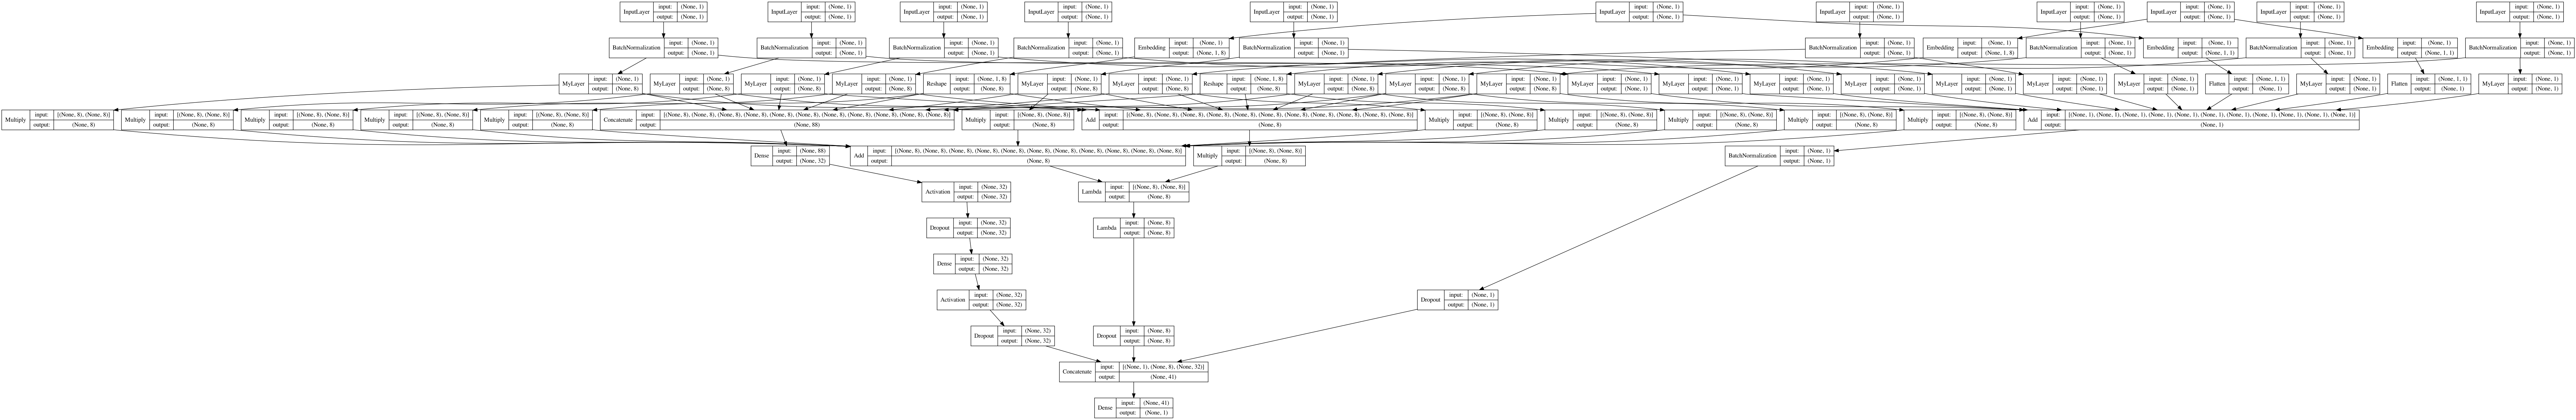

In [141]:
Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [ ]:
y_pred_d = model.predict(vali_X) 
y_pred_d

In [ ]:
layer_name = 'embed_0'
intermediate_layer_model = Model(inputs=model.input,
                             outputs=model.get_layer(layer_name).output)
test = X

# locationId_latent_vector = 
intermediate_layer_model.predict(test)